In [1]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("Agg") #Needed to save figures
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/hminle/miniconda2/e

In [2]:
from datetime import datetime
from bisect import bisect_right, bisect_left
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

In [3]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

## Load and Explore data

In [4]:
test_df = pd.read_csv('./data/test_table.csv')
user_df = pd.read_csv('./data/user_table.csv')

In [5]:
test_df.head(20)

user_id        date  source  device browser_language ads_channel  \
0    315281  2015-12-03  Direct     Web               ES         NaN   
1    497851  2015-12-04     Ads     Web               ES      Google   
2    848402  2015-12-04     Ads     Web               ES    Facebook   
3    290051  2015-12-03     Ads  Mobile            Other    Facebook   
4    548435  2015-11-30     Ads     Web               ES      Google   
5    540675  2015-12-03  Direct  Mobile               ES         NaN   
6    863394  2015-12-04     SEO  Mobile            Other         NaN   
7    527287  2015-12-03  Direct     Web               EN         NaN   
8    261625  2015-12-04  Direct  Mobile               ES         NaN   
9     10427  2015-12-04     Ads  Mobile               ES    Facebook   
10     8343  2015-11-30     Ads  Mobile               ES        Bing   
11    73335  2015-12-03     SEO     Web               ES         NaN   
12   744811  2015-12-01     SEO  Mobile               ES         NaN   
13   234023  2015-12-03     SEO     Web               ES         NaN   
14   207018  2015-12-03     Ads     Web               ES      Google   
15   103879  2015-11-30  Direct  Mobile               ES         NaN   
16   409295  2015-12-02  Direct     Web               ES         NaN   
17   313345  2015-12-01     SEO     Web               ES         NaN   
18   464816  2015-12-01  Direct     Web               ES         NaN   
19   740007  2015-11-30     SEO     Web               ES         NaN   

        browser  conversion  test  
0            IE           1     0  
1            IE           0     1  
2        Chrome           0     0  
3   Android_App           0     1  
4       FireFox           0     1  
5   Android_App           0     1  
6   Android_App           0     0  
7        Chrome           0     0  
8   Android_App           0     1  
9   Android_App           0     0  
10  Android_App           1     0  
11           IE           0     1  
12  Android_App           1     0  
13       Chrome           0     0  
14       Chrome           0     0  
15   Iphone_App           0     0  
16      FireFox           0     1  
17           IE           0     0  
18      FireFox           0     0  
19       Chrome           0     1

In [6]:
user_df.head(10)

user_id sex  age    country
0   765821   M   20     Mexico
1   343561   F   27  Nicaragua
2   118744   M   23   Colombia
3   987753   F   27  Venezuela
4   554597   F   20      Spain
5    62371   M   29    Ecuador
6   987967   M   31      Spain
7   499510   F   29   Paraguay
8   364726   F   29   Colombia
9   572551   M   21    Bolivia

In [7]:
test_df.describe()

user_id     conversion           test
count   453321.000000  453321.000000  453321.000000
mean    499937.514728       0.049579       0.476446
std     288665.193436       0.217073       0.499445
min          1.000000       0.000000       0.000000
25%     249816.000000       0.000000       0.000000
50%     500019.000000       0.000000       0.000000
75%     749522.000000       0.000000       1.000000
max    1000000.000000       1.000000       1.000000

In [8]:
user_df.describe()

user_id            age
count   452867.000000  452867.000000
mean    499944.805166      27.130740
std     288676.264784       6.776678
min          1.000000      18.000000
25%     249819.000000      22.000000
50%     500019.000000      26.000000
75%     749543.000000      31.000000
max    1000000.000000      70.000000

In [9]:
sns.countplot(x='browser_language', data=test_df)

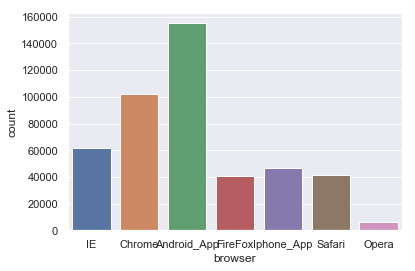

In [10]:
sns.countplot(x='browser', data=test_df)

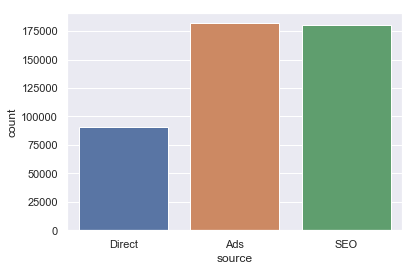

In [11]:
sns.countplot(x='source', data=test_df)

In [12]:
# Check No NaN
test_df.isna().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
dtype: int64

In [13]:
# Check No NaN
user_df.isna().sum()

user_id    0
sex        0
age        0
country    0
dtype: int64

In [14]:
# Left join
joined_df = test_df.merge(user_df, on='user_id', how='left')

In [15]:
joined_df.head(10)

user_id        date  source  device browser_language ads_channel  \
0   315281  2015-12-03  Direct     Web               ES         NaN   
1   497851  2015-12-04     Ads     Web               ES      Google   
2   848402  2015-12-04     Ads     Web               ES    Facebook   
3   290051  2015-12-03     Ads  Mobile            Other    Facebook   
4   548435  2015-11-30     Ads     Web               ES      Google   
5   540675  2015-12-03  Direct  Mobile               ES         NaN   
6   863394  2015-12-04     SEO  Mobile            Other         NaN   
7   527287  2015-12-03  Direct     Web               EN         NaN   
8   261625  2015-12-04  Direct  Mobile               ES         NaN   
9    10427  2015-12-04     Ads  Mobile               ES    Facebook   

       browser  conversion  test sex   age    country  
0           IE           1     0   M  32.0      Spain  
1           IE           0     1   M  21.0     Mexico  
2       Chrome           0     0   M  34.0      Spain  
3  Android_App           0     1   F  22.0     Mexico  
4      FireFox           0     1   M  19.0     Mexico  
5  Android_App           0     1   F  22.0  Venezuela  
6  Android_App           0     0   M  35.0     Mexico  
7       Chrome           0     0   M  22.0      Spain  
8  Android_App           0     1   M  31.0    Bolivia  
9  Android_App           0     0   F  33.0     Mexico

In [16]:
# Check No NaN
joined_df.isna().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
sex                    454
age                    454
country                454
dtype: int64

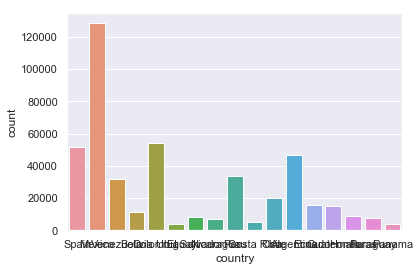

In [17]:
sns.countplot(x='country', data=joined_df)

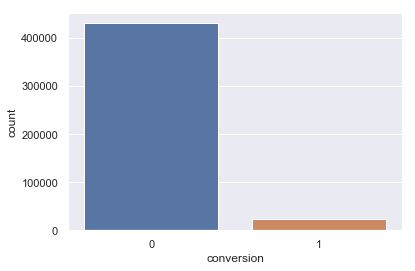

In [18]:
sns.countplot(x='conversion', data=joined_df)

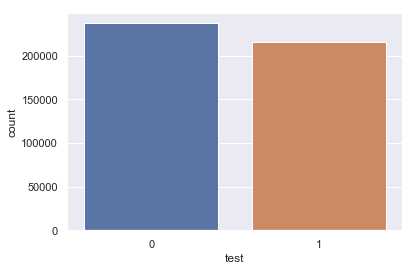

In [19]:
sns.countplot(x='test', data=joined_df)

## Confirmation the test

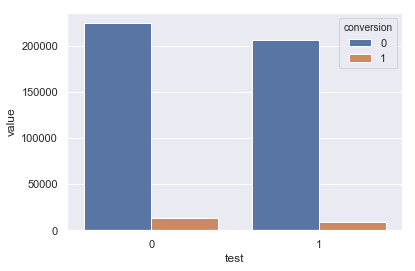

In [22]:
ct = pd.crosstab(joined_df['test'],joined_df['conversion'])
# now stack and reset
stacked = ct.stack().reset_index().rename(columns={0:'value'})

# plot grouped bar chart
sns.barplot(x=stacked.test, y=stacked.value, hue=stacked['conversion'])

In [26]:
# Conversion rate for non-localizing
joined_df[joined_df['test'] == 0]['conversion'].sum() / joined_df[joined_df['test'] == 0]['conversion'].count()

0.055178690306651276

In [27]:
# Conversion rate for localizing
joined_df[joined_df['test'] == 1]['conversion'].sum() / joined_df[joined_df['test'] == 1]['conversion'].count()

0.043424713982118966

From the above figure and comparison, we can tell that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better

In [28]:
country_grouped = joined_df.groupby('country')

In [35]:
for name, group in country_grouped:
    print('-----------------------')
    print(name)
    print('Shape of data: ' + str(group.shape))
    conversion_rate_non_localize = group[group['test'] == 0]['conversion'].sum() / group[group['test'] == 0]['conversion'].count()
    conversion_rate_localize = group[group['test'] == 1]['conversion'].sum() / group[group['test'] == 1]['conversion'].count()
    print('Conversion Rate for Non Localize {0:.3f}'.format(conversion_rate_non_localize))
    print('Conversion Rate for Localize {0:.3f}'.format(conversion_rate_localize))
    print('-----------------------')
    

-----------------------
Argentina
Shape of data: (46733, 12)
Conversion Rate for Non Localize 0.015
Conversion Rate for Localize 0.014
-----------------------
-----------------------
Bolivia
Shape of data: (11124, 12)
Conversion Rate for Non Localize 0.049
Conversion Rate for Localize 0.048
-----------------------
-----------------------
Chile
Shape of data: (19737, 12)
Conversion Rate for Non Localize 0.048
Conversion Rate for Localize 0.051
-----------------------
-----------------------
Colombia
Shape of data: (54060, 12)
Conversion Rate for Non Localize 0.052
Conversion Rate for Localize 0.051
-----------------------
-----------------------
Costa Rica
Shape of data: (5309, 12)
Conversion Rate for Non Localize 0.052
Conversion Rate for Localize 0.055
-----------------------
-----------------------
Ecuador
Shape of data: (15895, 12)
Conversion Rate for Non Localize 0.049
Conversion Rate for Localize 0.049
-----------------------
-----------------------
El Salvador
Shape of data: (817

/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


We can see that The localization is not really worse. In some countries, it performs better. For example, in Mexico, Chile, Costa Rica, Uruguay